In [1]:
""" import useful functions """

import emcee
import matplotlib.pyplot as plt 
import pyccl as ccl
import numpy as np
import scipy
%matplotlib inline

In [2]:
## TEST1: test matrix eigenval decomposition
"""

A = np.random.rand(2,6)                                                         # (n,m) means m columns n rows
AAt = np.matmul(np.transpose(A),A)
eigenvals,eigenvects = np.linalg.eig(AAt)
eigenvals = eigenvals.real
eigenvects = eigenvects.real

# Note: AAt = A*np.transpose(A) = eigenvects*np.diag(eigenvals)*np.transpose(eigenvects) -- sometimes it's not true - why? (TODO)

# put eigens in order of highest to lowest eigenvalue. U is ordered eigenvalues

ordered_eigenvals = [eigenvals[0]]
U = [eigenvects[0]]

for i in range(len(eigenvals) - 1): #becomes len del
    if eigenvals[i] > eigenvals[i + 1]:
        ordered_eigenvals = np.append(ordered_eigenvals, [eigenvals[i + 1]])
        U = np.append(U, [eigenvects[i + 1]], axis = 0)
    else:
        ordered_eigenvals = np.append(ordered_eigenvals[:len(ordered_eigenvals)-1],
                                      np.append([eigenvals[i + 1]],ordered_eigenvals[len(ordered_eigenvals)-1:len(ordered_eigenvals)]))        
        
        U = np.append(U[:len(ordered_eigenvals)-1],
                      np.append([eigenvects[i + 1]],U[len(ordered_eigenvals)-1:len(ordered_eigenvals)] , axis = 0), axis = 0)

# find Sigma
Sigma = np.append(np.diag(ordered_eigenvals[:len(A)]), np.zeros((len(ordered_eigenvals) - len(A), len(A))), axis=0) #becomes len eigenvals

# Find USigma
USigma = np.matmul(U,Sigma)

# Find USigma and A in square form (see notes for why)

ASquare = np.append(A, np.zeros((len(A[0]) - len(A), len(A[0]))), axis = 0)
Q1 = np.zeros((len(A), len(A[0]) - len(A)))
Q2 = np.identity(len(A[0]) - len(A))
USigmaSquare = (np.append(USigma, np.append(Q1,Q2, axis = 0), axis = 1))
del Q1, Q2

# find Vt
Vt = np.matmul(np.linalg.inv(USigmaSquare),np.transpose(ASquare))

print("Vt = ", Vt)

# for the test to be successful, Vt should be a 6x6 matrix with zeros everywhere excpet for the 2x2 corner

del AAt,eigenvals,eigenvects, ordered_eigenvals,U , Sigma ,USigma,ASquare,USigmaSquare

"""

'\n\nA = np.random.rand(2,6)                                                         # (n,m) means m columns n rows\nAAt = np.matmul(np.transpose(A),A)\neigenvals,eigenvects = np.linalg.eig(AAt)\neigenvals = eigenvals.real\neigenvects = eigenvects.real\n\n# Note: AAt = A*np.transpose(A) = eigenvects*np.diag(eigenvals)*np.transpose(eigenvects) -- sometimes it\'s not true - why? (TODO)\n\n# put eigens in order of highest to lowest eigenvalue. U is ordered eigenvalues\n\nordered_eigenvals = [eigenvals[0]]\nU = [eigenvects[0]]\n\nfor i in range(len(eigenvals) - 1): #becomes len del\n    if eigenvals[i] > eigenvals[i + 1]:\n        ordered_eigenvals = np.append(ordered_eigenvals, [eigenvals[i + 1]])\n        U = np.append(U, [eigenvects[i + 1]], axis = 0)\n    else:\n        ordered_eigenvals = np.append(ordered_eigenvals[:len(ordered_eigenvals)-1],\n                                      np.append([eigenvals[i + 1]],ordered_eigenvals[len(ordered_eigenvals)-1:len(ordered_eigenvals)]))       

In [3]:
## EXAMPLE1: example of how to import power spectrum

"""
# import data P(k) and k for some simulation

with open('/home/c2042999/C_EEl_project/C_EEl_data/Test_sim.dat',"r") as data:
    d = np.loadtxt(data)
    d = np.transpose(d)
    z = d[0]
    k = d[1]
    Pk = d[2]

plt.plot(k[:288],Pk[:288])
plt.xscale('log')
plt.yscale('log')

del d, z, k, Pk
"""

'\n# import data P(k) and k for some simulation\n\nwith open(\'/home/c2042999/C_EEl_project/C_EEl_data/Test_sim.dat\',"r") as data:\n    d = np.loadtxt(data)\n    d = np.transpose(d)\n    z = d[0]\n    k = d[1]\n    Pk = d[2]\n\nplt.plot(k[:288],Pk[:288])\nplt.xscale(\'log\')\nplt.yscale(\'log\')\n\ndel d, z, k, Pk\n'

In [4]:
""" Get a binned redshift distribution - defining functions """

# define the reasonable redshift distribution (not normalized yet)

def redshiftdist(z):
    
    alpha = 1.27
    beta = 1.02
    z0 = 0.5
    pz = z**alpha * np.exp(-(z / z0)**beta)                                # Redshift distribution, p(z)
    return pz

# complete binning of z so that integral of redshiftdist(z) between bins stays the same. Need redshiftdist(z) to be Normalized
# (in limit of large z linspace)

def bindist(z, n_bins):
                                                                          # have redshiftdist(z), z 
                                                                          # find bins: integrate between 0 and i redshift(z)
                                                                          #            if integral => 1/n_bin, that is a bin
                                                                          #            repeat for 2/n_bin, 3/n_bin, etc
    pz = redshiftdist(z)
    N = scipy.integrate.simps(pz, z)                                      # Normalization factor
    pz = pz/N
    j = 1
    bins = np.zeros(int(n_bins + 1))
    for i in range(len(z) - 10):
        I = scipy.integrate.simps(pz[0 : i + 10], z[0 : i + 10])
        if I >= j / n_bins:
            bins[j] = z[i + 10]
            j += 1
    bins[int(n_bins)] = z[len(z) - 1]
    bins[0] = z[0]
    return bins

# define gaussian photo-z uncertainties

def gaussianphotoz(zs , zp):
    I = np.exp(-np.power(zs - zp , 2.) / (2 * np.power(0.05 * (1 + zp) , 2.)))
    N = scipy.integrate.simps(I , zs)
    return I/(N)

# bins distribution for redshiftdist(z) in n_bins with same number of galaxies in each bin, smoothened by gaussianphotoz(zs , zp) kernel

def binning_redshiftdist(z , n_bins):
    
    N = scipy.integrate.simps(redshiftdist(z), z)

    # complete binning
    bin_edges = bindist(z, n_bins)

    # smoothing redshift distribution with gaussian kernel

    Sum = 0                                                                       # find what the sum of normalized plots is. Want this equal to Rdist
    binned_redshiftdist = np.zeros((len(bin_edges) - 1, len(z)))

    for i in range(len(bin_edges) - 1):
        Rdist_new = np.zeros(len(z))
        conv = np.zeros(len(z))

        for j in range(len(z)):                                                  # define binned redshift functions before smoothing
            if z[j] >= bin_edges[i] and z[j] <= bin_edges[i+1]:
                Rdist_new[j] = redshiftdist(z[j])/(N)
    
        for j in range(len(z)):                                                  # smoothen distributions by convolving with a gaussian kernel
            conv[j] = scipy.integrate.simps(Rdist_new * gaussianphotoz(z , z[j]) , z)
    
        binned_redshiftdist[i] = conv
    
        Sum += conv
    
    #plt.plot(zp, conv)
    return binned_redshiftdist , Sum

In [5]:
""" Get a binned redshift distribution - getting the actual distribution """

# find normalized redshift distribution

z = np.linspace(0 , 5.0 , int(1e4))

Rdist = redshiftdist(z)
N = scipy.integrate.simps(Rdist, z)                                    # Normalization factor
Rdist = Rdist/N

Binned_distribution = binning_redshiftdist(z , 10)[0]

In [6]:
## TEST2: Plots to check binned redshift distribution

"""
plt.plot(z , Rdist)
plt.plot(z ,Binned_distribution[0])
plt.plot(z ,Binned_distribution[1])
plt.plot(z ,Binned_distribution[2])
plt.plot(z ,Binned_distribution[9])
"""

'\nplt.plot(z , Rdist)\nplt.plot(z ,Binned_distribution[0])\nplt.plot(z ,Binned_distribution[1])\nplt.plot(z ,Binned_distribution[2])\nplt.plot(z ,Binned_distribution[9])\n'

In [7]:
""" Finding C_ell_array (our training data) - defining function """

def findC_ell_array(ell_min, ell_max, ell_bin_num, cosmo, z, Binned_distribution):
    
    #find ell arrays and empty arrays
    
    ell = np.arange(ell_min, ell_max)
    C_ell = np.zeros((len(cosmo),len(Binned_distribution), len(Binned_distribution), len(ell)))
    
    # define quantities for binning C_ell
    
    C_ell_array = []
    
    ell_binned_limits = np.logspace(np.log10(ell_min),np.log10(ell_max),num=ell_bin_num + 1)
    bin_edge1 = ell_binned_limits[:-1]
    bin_edge2 = ell_binned_limits[1:]
    ell_binned = (bin_edge1 + bin_edge2) / 2
    
    longell = []
    for i in range(int(len(cosmo)*((len(Binned_distribution) + 1) * len(Binned_distribution) / 2))):
        longell = np.append(longell, ell_binned)

    # find C_ell for a range of ells, then bin these to find C_ell_array 

    #Note: this gives list of C_ell[i][j][k][ell]: ith cosmology, cross correlated over jth and kth binned redshift 
    #      distribution for each binned value of ell. 

    for i in range(len(cosmo)):
        for j in range(len(Binned_distribution)):
            for k in range(len(Binned_distribution)):
                if k > j:
                    break
                tracer1 = ccl.WeakLensingTracer(cosmo[i], dndz=(z, Binned_distribution[j])) # TODO normalization
                tracer2 = ccl.WeakLensingTracer(cosmo[i], dndz=(z, Binned_distribution[k]))
                C_ell[i][j][k] = ccl.angular_cl(cosmo[i], tracer1, tracer2, ell)            # uses non-linear matter power spectrum stored in `cosmo`
            
                # bin ell
                bin_means, bin_edges, binnumber = scipy.stats.binned_statistic(ell, C_ell[i][j][k], statistic='mean', 
                                                                               bins= ell_binned_limits)
    
                C_ell_array = np.append(C_ell_array, bin_means)
    return longell, C_ell_array

In [31]:
""" Create training data: find P_del non-linear and linear for a set of 9 power spectra with different cosmologies,
with Omega_m = (0.23 , 0.31), sigma8 = [0.7 , 1.2]
given Omega_m = 0.27 +/- 0.04, binned sigma8 from DESY3 (1) paper """

# define cosmological parameters

cosmo = np.zeros((3,3) , dtype=object)

c = 3e5                                                                  # km/s

for i in range(len(cosmo)):
    for j in range(len(cosmo[0])):
        cosmo[i][j] = ccl.Cosmology(Omega_c = 0.23 , # + (0.04 * i), 
                      Omega_b = 0.045, 
                      h = 0.67, 
                      n_s = 0.96 + (0.04 * i),
                      sigma8 = 0.7 + 0.25 * j, 
                      transfer_function='bbks')
cosmo = np.append(np.append(cosmo[0] , cosmo[1]) , cosmo[2])

""" -- NOTES on C_ell --
# redshift distribution is Binned_distribution from above. Doesn't need to be normalized, renormalized in ccl.angular_cl
# note: zdist = Binned_distribution, as a function of z
# binned over 10 redshift distributions. That means that C_ell[i][j][k] is the C_ell for the ith cosmology, cross correlated over
# jth and kth redshift distribution, as a function of ell."""

# define ell and C_ell shapes 

ell_min = 2
ell_max = 2060

# define quantities for binning of ell

ell_bin_num = 18

# find C_ell for non-linear matter power spectrum

C_ell_data = findC_ell_array(ell_min, ell_max, ell_bin_num, cosmo, z, Binned_distribution)

longell = C_ell_data[0]
C_ell_array = C_ell_data[1]

del C_ell_data

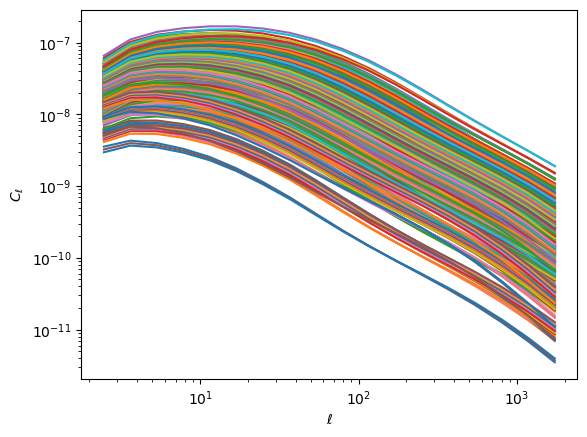

In [32]:
## TEST3: Plot C_ell to see if shapes are reasonable


for i in range(int(len(C_ell_array)/18 - 1)):
    plt.plot(longell[int(i*18):int((i+1)*18)], C_ell_array[int(i*18):int((i+1)*18)])

plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.xscale('log')
plt.yscale('log')
plt.show()


# comment: sigma8 changes the y intercept (as sigma8 increases the value of y-intercept increases
#          OmegaM changes the power spectrum behaviour at high P (as OmegaM increases Cl increases at high l)

In [33]:
## TEST4: Animation of C_ell to see if there is a pattern

"""
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np

fig, ax = plt.subplots()
ax.axis([0,1000,0,1e-7])
l, = ax.plot([],[])

def animate(i):
    l.set_data(longell[int(i*18):int((i+1)*18)], C_ell_array[int(i*18):int((i+1)*18)])
    
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=int(len(C_ell_array)/18 - 1))

from IPython.display import HTML
HTML(ani.to_jshtml())
"""

'\nimport matplotlib.pyplot as plt\nimport matplotlib.animation\nimport numpy as np\n\nfig, ax = plt.subplots()\nax.axis([0,1000,0,1e-7])\nl, = ax.plot([],[])\n\ndef animate(i):\n    l.set_data(longell[int(i*18):int((i+1)*18)], C_ell_array[int(i*18):int((i+1)*18)])\n    \nani = matplotlib.animation.FuncAnimation(fig, animate, frames=int(len(C_ell_array)/18 - 1))\n\nfrom IPython.display import HTML\nHTML(ani.to_jshtml())\n'

In [34]:
"""put C_ell data in right format"""

ell = longell[0:990]
B_data = np.zeros((len(cosmo), len(ell)))
for i in range(len(cosmo)):
    B_data[i] = C_ell_array[int(i*55*18):int((i+1)*55*18)]



In [35]:
"""Find C_ell with linear matter power spectrum"""

# define cosmological parameters for linear power spec

cosmo1 = np.zeros((3,3) , dtype=object)

for i in range(len(cosmo1)):
    for j in range(len(cosmo1[0])):
        cosmo1[i][j] = ccl.Cosmology(Omega_c = 0.23, #+ (0.04 * i), 
                      Omega_b = 0.045, 
                      h = 0.67, 
                      n_s = 0.96 + (0.04 * i),
                      sigma8 = 0.7 + 0.25 * j, 
                      transfer_function='bbks',
                      matter_power_spectrum='linear')
cosmo1 = np.append(np.append(cosmo1[0] , cosmo1[1]) , cosmo1[2])

# ell and C_ell shapes, binning taken from above to be ell_min = 2, ell_max = 2060, ell_bin_num = 18

# find C_ell

C_ell_data_linear = findC_ell_array(ell_min, ell_max, ell_bin_num, cosmo1, z, Binned_distribution)

C_ell_array_linear = C_ell_data_linear[1]

del C_ell_data_linear

In [36]:
"""put C_ell data in right format"""

#Note: this is for all the same cosmo! TODO WHY!!!!!!!
M_data = np.zeros((len(cosmo1), len(ell)))
for i in range(len(cosmo)):
    M_throwaway = np.append(C_ell_array_linear[int(55*i*18):int(55*18*i + 18)],C_ell_array_linear[int(55*i*18):int(55*18*i + 18)]) # 36
    M1_throwaway = np.append(M_throwaway,M_throwaway) # 72
    M4_throwaway = np.append(M1_throwaway,M1_throwaway) # 144
    M2_throwaway = np.append(M4_throwaway,M4_throwaway) # 288
    M3_throwaway = np.append(M2_throwaway,M2_throwaway) # 576
    M_data[i] = np.append(np.append(np.append(np.append(M3_throwaway,M2_throwaway),M1_throwaway),M_throwaway),C_ell_array_linear[int(55*i*18):int(55*18*i + 18)])
    
del M_throwaway,M1_throwaway,M2_throwaway,M3_throwaway, M4_throwaway

"""
# For different cosmos for each data point
for i in range(len(cosmo)):
    M_data[i] = C_ell_array_linear[int(55*i*18):int(55*18*(i + 1))]
"""
    

'\n# For different cosmos for each data point\nfor i in range(len(cosmo)):\n    M_data[i] = C_ell_array_linear[int(55*i*18):int(55*18*(i + 1))]\n'

Text(0, 0.5, '$\\frac{C^{00}_{NL}(\\ell)}{C^{00}_{Linear}(\\ell)} - 1$')

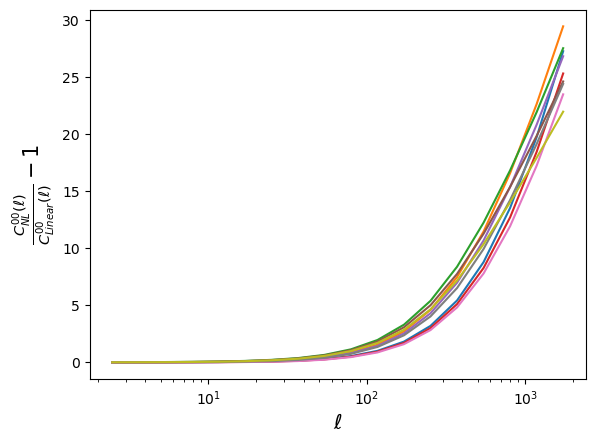

In [37]:
# TEST5: Plot processed data to compare with Huang et al 2020


frac = (B_data / M_data) - 1

plt.xscale('log')
#plt.ylim(0,0.5)
for i in range(len(cosmo)):
    plt.plot(ell[0:18],frac[i][0:18])

plt.xlabel(r'$\ell$', size = 15)
plt.ylabel(r'$\frac{C^{00}_{NL}(\ell)}{C^{00}_{Linear}(\ell)} - 1$', size = 15)

Text(0, 0.5, '$C^{00}_{NL}(\\ell) - C^{00}_{Linear}(\\ell)$')

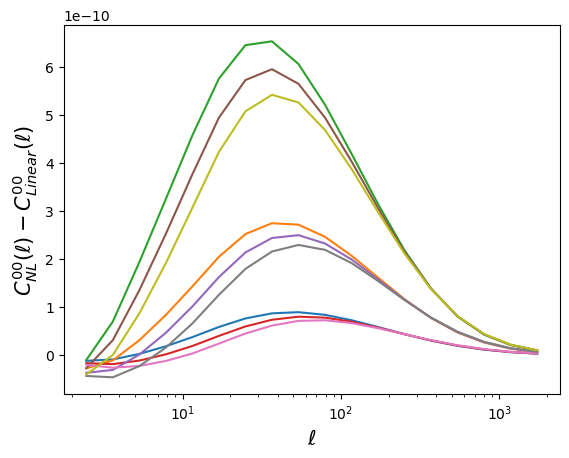

In [38]:
# TEST5: Plot processed data to compare with Huang et al 2020


sub = (B_data - M_data) 

plt.xscale('log')
#plt.ylim(0,0.5)
for i in range(len(cosmo)):
    plt.plot(ell[0:18],sub[i][0:18])

plt.xlabel(r'$\ell$', size = 15)
plt.ylabel(r'$C^{00}_{NL}(\ell) - C^{00}_{Linear}(\ell)$', size = 15)

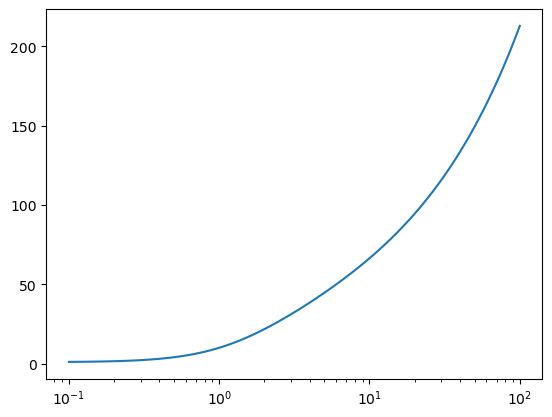

In [39]:
# TEST6: Plot power spectra linear/non-linear to compare to Huang et al 2020


k = np.logspace(np.log10(0.1),np.log10(100),num=100)
plt.plot(k, ccl.power.nonlin_power(cosmo[0], k, 1) / ccl.power.linear_power(cosmo[0], k, 1))

plt.xscale("log")



# Matrix conventions in python

A = $\begin{bmatrix}
a00 & a01 & a02\\
a10 & a11 & a12
\end{bmatrix}$ = [[a00, a01, a02], [a10, a11, a12]], with aij = A[i][j]

A[0] is first row, A[:][0] is first column

len(A) = number of rows, len(A[0]) = number of columns

AxB = np.matmul(A,B)

for B = $\begin{bmatrix}
b00 & b01 & b02\\
b10 & b11 & b12
\end{bmatrix}$, np.append(A,B, axis = 0) = A = $\begin{bmatrix}
a00 & a01 & a02\\
a10 & a11 & a12\\
b00 & b01 & b02\\
b10 & b11 & b12
\end{bmatrix}$ 

In [40]:
"""PCA decomposition - define function to find rotation matrix U - TODO check """

def findU_PCAmethod(Delta):
    
    # find eigenvectors and eigenvalues of AAt = Delta*Deltat
    AAt = np.matmul(Delta,np.transpose(Delta))
    eigenvals,eigenvects = np.linalg.eig(AAt)

    eigenvals = eigenvals.real
    eigenvects = eigenvects.real

    # Put eigenvectors and eigenvalues in right order, find U

    ordered_eigenvals = [eigenvals[0]]
    U = [eigenvects[0]]
  
    for i in range(len(eigenvals) - 1): #becomes len del
        if eigenvals[i] > eigenvals[i + 1]:
            ordered_eigenvals = np.append(ordered_eigenvals, [eigenvals[i + 1]])
            U = np.append(U, [eigenvects[i + 1]], axis = 0)
        else:
            ordered_eigenvals = np.append(ordered_eigenvals[:len(ordered_eigenvals)-1],
                                          np.append([eigenvals[i + 1]],ordered_eigenvals[len(ordered_eigenvals)-1:len(ordered_eigenvals)]))        
        
            U = np.append(U[:len(ordered_eigenvals)-1],
                          np.append([eigenvects[i + 1]],U[len(ordered_eigenvals)-1:len(ordered_eigenvals)] , axis = 0), axis = 0)

    return U

In [41]:
""" PCA decomposition"""

# Find Delta as 990 rows and 9 columns
Delta = B_data - M_data

Delta = np.transpose(Delta)

U = findU_PCAmethod(Delta)

In [42]:
# TEST 7: Check if there exists a Vt that allows for PCA decomposition - TODO Look over this, still very unsure it is correct

"""
# find Sigma
Sigma = np.append(np.diag(ordered_eigenvals[:len(Delta[0])]), np.zeros((len(ordered_eigenvals) - len(Delta[0]), len(Delta[0]))), axis=0) #becomes len eigenvals

# Find USigma
USigma = np.matmul(U,Sigma)

# Find USigma and A in square form (see notes for why)

DelSquare = np.append(Delta, np.zeros((len(Delta), len(Delta) - len(Delta[0]))), axis = 1)
DelSquare = np.transpose(DelSquare)
Q1 = np.zeros((len(Delta[0]), len(Delta) - len(Delta[0])))
Q2 = np.identity(len(Delta) - len(Delta[0]))
USigmaSquare = (np.append(USigma, np.append(Q1,Q2, axis = 0), axis = 1))
USigmaSquare = np.transpose(USigmaSquare)

# find Vt
Vt = np.matmul(np.linalg.inv(USigmaSquare),np.transpose(DelSquare))

print("Vt = ", Vt)

del Q1, Q2, Sigma, USigma, DelSquare,USigmaSquare, Vt

"""

'\n# find Sigma\nSigma = np.append(np.diag(ordered_eigenvals[:len(Delta[0])]), np.zeros((len(ordered_eigenvals) - len(Delta[0]), len(Delta[0]))), axis=0) #becomes len eigenvals\n\n# Find USigma\nUSigma = np.matmul(U,Sigma)\n\n# Find USigma and A in square form (see notes for why)\n\nDelSquare = np.append(Delta, np.zeros((len(Delta), len(Delta) - len(Delta[0]))), axis = 1)\nDelSquare = np.transpose(DelSquare)\nQ1 = np.zeros((len(Delta[0]), len(Delta) - len(Delta[0])))\nQ2 = np.identity(len(Delta) - len(Delta[0]))\nUSigmaSquare = (np.append(USigma, np.append(Q1,Q2, axis = 0), axis = 1))\nUSigmaSquare = np.transpose(USigmaSquare)\n\n# find Vt\nVt = np.matmul(np.linalg.inv(USigmaSquare),np.transpose(DelSquare))\n\nprint("Vt = ", Vt)\n\ndel Q1, Q2, Sigma, USigma, DelSquare,USigmaSquare, Vt\n\n'

990
990


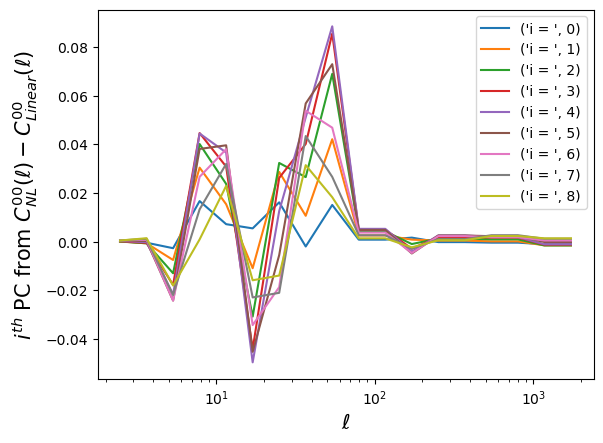

In [43]:
print(len(U))
print(len(U[0]))

for i in range(9):
    plt.plot(ell[0:18], U[i][0: 18], label = ("i = ",i))
    
plt.legend()
    
plt.xlabel(r'$\ell$', size = 15)
plt.ylabel(r'$i^{th}$ PC from $C^{00}_{NL}(\ell) - C^{00}_{Linear}(\ell)$', size = 15)

plt.xscale("log")

In [ ]:
# del C_ell_array, cosmo, longell, C_ell_array_linear, cosmo1, Binned_distribution, ani